# SLR TRAINING

In [13]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

# Define Paths
DATA_PATH = '/content/drive/MyDrive/Dataset'
actions = np.array(['hello', 'thank_you', 'i_love_you', 'yes', 'no'])
no_sequences = 50
sequence_length = 30

Mounted at /content/drive


In [25]:

# Load and preprocess data
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(1, no_sequences + 1):
        window = []
        for frame_num in range(sequence_length):
            file_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
            if os.path.isfile(file_path):
                res = np.load(file_path)
                window.append(res)
            else:
                print(f"Missing file: {file_path}")
                window.append(np.zeros((33 * 4 + 468 * 3 + 21 * 3 * 2,)))  # Add empty keypoints if file is missing
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = np.array(labels)


Missing file: /content/drive/MyDrive/Dataset/hello/50/0.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/1.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/2.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/3.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/4.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/5.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/6.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/7.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/8.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/9.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/10.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/11.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/12.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/13.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/14.npy
Missing file: /content/drive/MyDrive/Dataset/hello/50/15.npy
Missing file: /content/drive/MyDri

In [26]:
# Normalize the data
X = np.array(sequences)
X = X / np.max(X)  # Normalize the data

y = np.array(labels)

In [27]:
# One-hot encoding of labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
if y.ndim == 1:
    y = np.expand_dims(y, axis=-1)

In [28]:
# Ensure y is 2D (samples, num_classes)
if y.shape[1] == 1:
    y = np.hstack((1 - y, y))

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Data Augmentation
augmented_data = []
augmented_labels = []

for i in range(len(X_train)):
    augmented_data.append(X_train[i])
    augmented_labels.append(y_train[i])
    augmented_sequences = augment_data(X_train[i])
    for seq in augmented_sequences:
        augmented_data.append(seq)
        augmented_labels.append(y_train[i])

X_train = np.array(augmented_data)
y_train = np.array(augmented_labels)

In [72]:
# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)), input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=False, activation='relu', kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model with a modified learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [73]:
# Early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)


In [80]:
# Train the model
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

history = model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[tb_callback, early_stopping, checkpoint, reduce_lr], validation_data=(X_test, y_test))


Epoch 1/200
16/16 [==============================] - 3s 192ms/step - loss: 22.4623 - categorical_accuracy: 0.8390 - val_loss: 22.3260 - val_categorical_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 2/200
16/16 [==============================] - 3s 183ms/step - loss: 22.3836 - categorical_accuracy: 0.8390 - val_loss: 22.2846 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 3/200
16/16 [==============================] - 3s 190ms/step - loss: 22.2937 - categorical_accuracy: 0.8720 - val_loss: 22.2246 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 4/200
16/16 [==============================] - 3s 183ms/step - loss: 22.2214 - categorical_accuracy: 0.8680 - val_loss: 22.1920 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 5/200
16/16 [==============================] - 3s 184ms/step - loss: 22.1990 - categorical_accuracy: 0.8500 - val_loss: 22.1692 - val_categorical_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 6/200
16/16 [==============================] - 3s 188ms/step - l

In [81]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

2/2 - 0s - loss: 20.3489 - categorical_accuracy: 0.9400 - 85ms/epoch - 42ms/step
Test accuracy: 0.94


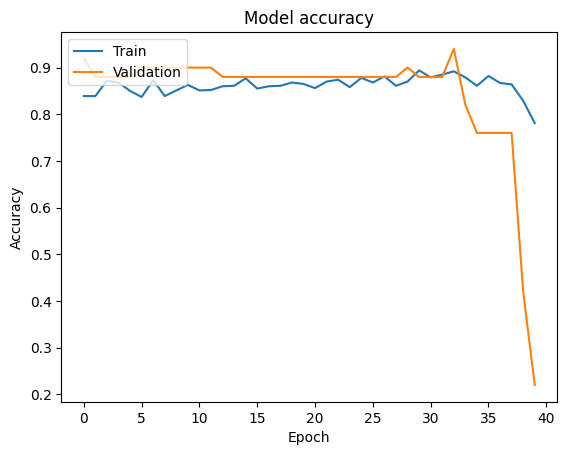

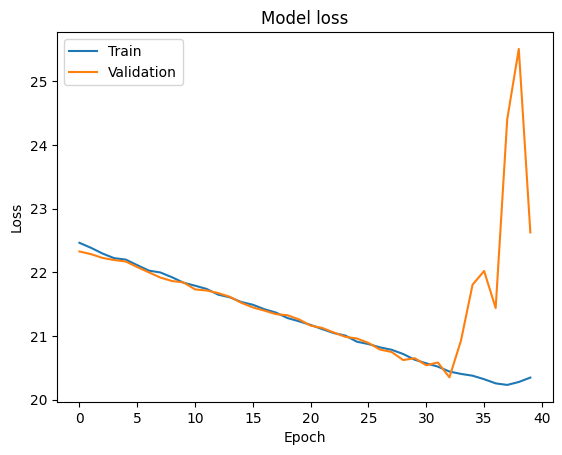

In [82]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('sign_language_model.h5')